<p style="text-align:center;font-size:200%;"><b>Comparing Object Detection algorithms</b></p>
<p style="text-align:center;font-size:150%;"><b>on vehicles in the UK</b></p>
<p style="text-align:center;font-size:100%;"><b>Ehsan Taati(s5220221),Brandon Bule(s4446157)</b></p>
<p style="text-align:center;font-size:100%;"><b>Sebastien Perrier(i7460603),Joe Maclachlan(s5221746)</b></p>
    
    

In [3]:
import pandas as pd
import numpy as np
import os,sys
import torch
from tqdm.notebook import trange,tqdm
import PIL
from PIL import Image, ImageFile
from torchvision import transforms
import torchvision
from torch.autograd import Variable
from skimage import io
import sklearn.utils
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import random
import seaborn as sns
Tensor = torch.cuda.FloatTensor
import warnings
warnings.filterwarnings('ignore')

In [4]:
# for the trial video run
!pip install filterpy
!conda install numba -y

Solving environment: done

# All requested packages already installed.



In [5]:
# to print bold stuff
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# some PIL images didnt read properly this line solves it
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [6]:
# to get the label and bbox of the dataset
def bbox_inp(img_idx):
    cls_name = frames_list.iloc[img_idx,1]
    xc = frames_list.iloc[img_idx,2]
    yc = frames_list.iloc[img_idx,3]
    w = frames_list.iloc[img_idx,4]
    h = frames_list.iloc[img_idx,4]
    
    return cls_name,[xc,yc,w,h]

In [7]:
# to draw boundig boxes
def draw_rect(ax, xy, w, h):
    patch = ax.add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='yellow', lw=2))
    patch.set_path_effects([patheffects.Stroke(linewidth=3, foreground='black'), patheffects.Normal()])

In [8]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [9]:
# to display the input images from dataset
def show_inp(img_idx,lbl,bbox,ax=None,root_dir = '../Frames/'):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    img = PIL.Image.open(img_path)
    img = np.array(img)
    ax = show_img(img,ax, title=frames_list.iloc[img_idx,1])
    xc,yc,w,h = bbox[0],bbox[1],bbox[2],bbox[3]

    xtl = xc-w/2
    ytl = yc-w/2
    
    draw_rect(ax, [xtl, ytl], w, h)

In [10]:
# To detect the width and height of the input image, using for padding the input images
def detect_image(img):
    # scale image
    ratio = min(inp_w/img.size[0], inp_h/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    
    
    return imh,imw

In [11]:
def precision(TP,FP):
    
    return division(TP,TP+FP)

def recall(TP,FN):
    
    return division(TP,TP+FN)

def F1(precision,recall):
    return 2*(division(precision*recall,precision+recall))

In [12]:
# to avoid 0/0
def division(n, d):
    return n / d if d else 0

# Introduction

Object detection performance varies with degrees of precision and accuracy across different spectrum of conditions such as lighting, weather, hardware limitations and more (Sivaraman & Trivedi, 2013). Object detection will always be at the forefront on testing and experimentation due to the possibility of maintaining driver awareness that can cause accidents and deaths (Dhamanam et al., 2019). It is important to test the robustness of a detector as we are introduced more object detection methods now and in the future. 
We used three pre-trained object detection algorithms as follows:<br>
* <a href = "https://github.com/eriklindernoren/PyTorch-YOLOv3">YOLOV3</a>
* FAST-RCNN
* <a href ="https://github.com/qfgaohao/pytorch-ssd">SSD-VGG16</a> 

In this Notebook we first will explain how data is collected and prepared. In section 3 the models will be introduced and examined on the dataset. The results will be discussed in section 4. Afterward, we would apply FAST-RCNN as the best performance algorithm  to a live run.

# Methodology

The main objective of this project is to compare three object detectors to detect various types of vehicles. We will be collecting video footage of different weather conditions and apply each object detectors and measure its performance. The video will be taken on similar places within Bournemouth, UK.

The different weather condition are as follows:
 - Clear Day
 - Rain
 - Night time

The following performance measure will be used to compare the object detectors
 - Accuracy
is a simple performance measure that reports the ratio of correctly predicted observations against the total amount of observations. The effectiveness of accuracy as a performance measure is dependant on the balance of the datasets. On symmetrical datasets, it is effective, but on highly imbalanced datasets it is not. For example, an algorithm could predict all outputs to be the majority class, resulting in a high accuracy score, even though it misses all of the minority class. 

This can be calculated with: True Positives(TP) + True Negatives(TN)/TP + False Positives(FP) + False Negatives(FN) + TN
 - Precision
is the ratio of correctly predicted true observations against the total amount of predicted true observations. For example, in the context of this project, for all the objects that are labelled as car, how many actually were cars? High precision means there is a low false positive rate.

This can be calculated with: TP/TP+FP
 - Recall
Recall is similiar to precision, but instead of calculating the ratio of correctly predicted true observations against the total amount of predicted true observations, it calculates against all observations in the actual class. For example, for all the objects that are cars, how many were correctly labelled?

This can be calculated with:  TP/TP+FN
 
 - F1 score
This is the final score metric we will be using. F1 score is simply the weighted average between precision and recall. It considers both precision and recall to be of equal value, hence if one metric is more important than the other depending on the task, one should look at the precision and recall scores individually. 

This can be calculated with: 2*(Recall * Precision) / (Recall + Precision)

# Data Collection

Video footages were taken at opputunistic times when the weather met the conditions. All footage were taken within a vehicle dashcam. Video capture was generally steady at 30 fps and no noticeble measurement difference between the conditions. 

There were various factors that we could not control for such as number of objects per class.

# Preparing data

After collecting footages, we used <a href="https://github.com/alexandre01/UltimateLabeling">UltimateLabeling</a> to annotate the videos. This tool not only extracts frames from videos easily, but also it has been equipped with some handy tools for annotation. The output is a csv file in the format: "class_id", "xc", "yc", "w", "h"

<br>Data is accessible <a href="https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5220221_bournemouth_ac_uk/En-25u9q7SJDvBzjFPJLomkBNfHtgB53zJsT2Ci5nWFLGQ?e=SVpRvx"><b>here</b></a>. YOLOV3 and FAST-RCNN had pretrained weights on MSCOCO dataset and SSD-VGG16 on VOC datasets.So we considered the following labels for our dataset due to the limitations of the pre-trained weights as follows:

* For YOLOv3 and FAST-RCNN four classes: car, truck, bus and motorcycle
* For SSD three classes: car, bus and motorcycle

Doing annotation, all the output csv files have been merged in a single file to start inference with the networks.We used this <a href="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/ERlnKd89qqNJlj_7ajNfLiUB2aUCK9IaPefKO3r-9i2Tmg?e=gcqeeg">notebook</a> to merge all the csv file into a single file(Download the csv_file from <a href="https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5220221_bournemouth_ac_uk/En-25u9q7SJDvBzjFPJLomkBNfHtgB53zJsT2Ci5nWFLGQ?e=hjofFo">here</a>).

In [13]:
csv_file = 'mergedlbls.csv'
frames_list = pd.read_csv(csv_file)
frames_list_rain = frames_list[frames_list['im_name'].str.contains('Rainy')]
frames_list_night = frames_list[frames_list['im_name'].str.contains('Night')]
frames_list_clear = frames_list[frames_list['im_name'].str.contains('Clear')]
frames_list.head()

,im_name,class_id,Xc,Yc,w,h
0,ClearDay3/00000.jpg,car,1376,502,68,23
1,ClearDay3/00000.jpg,car,1144,490,23,17
2,ClearDay3/00001.jpg,car,1481,512,91,34
3,ClearDay3/00001.jpg,car,1160,494,25,17
4,ClearDay3/00002.jpg,car,1653,517,124,49


Then to be able to classify the results of inferences per condition, as it was mentioned in the proposal, the following codes employed to count the number of classes per conditions.

In [14]:
cls_cnt = frames_list.iloc[:,1].value_counts()
cls_cnt_rain = frames_list[frames_list['im_name'].str.contains('Rainy')].iloc[:,1].value_counts().to_dict()
cls_cnt_night = frames_list[frames_list['im_name'].str.contains('Night')].iloc[:,1].value_counts().to_dict()
cls_cnt_clear = frames_list[frames_list['im_name'].str.contains('Clear')].iloc[:,1].value_counts().to_dict()
class_total =cls_cnt.to_dict()

The distribution of each classes in the dataset is as follows:

In [15]:
class_total

{'car': 28627, 'truck': 786, 'motorcycle': 101, 'bus': 25}

As our footages have been recoding on the motorway, car was the most frequent object in the dataset while  bus was the least frequent one.

# Models

## YOLOV3

We used YOLOV3 for our first object detection experiment.
YOLOV3 (You only look once) is one of many real-time object detection systems. Objection detection, an application of computer vision and image processing is used to detect instances of semantic objects pertaining to a certain class (Dasiopoulou et al. 2005). In the case of this project, the classes we will be attempting to detect are various different motor-vehicles. 
As described by the creators of YOLO, this detection differs to other detection systems as it does not repurpose classifiers or localizers to perform detection, avoiding to apply the model to an image at various locations and scales. Yolo, on the other hand, takes a different approach to its detection methods. YOLO will apply a single neural network to an entire image, dividing the image into regions, and then predict bounding boxes alongside probabilities that the predictions are correct. Multiple advantages are claimed over other object detection systems, by its creators. Namely, it looks at the entire image at test time, meaning predictions are informed by global context of the image. Importantly, using a single network evaluation system means it works considerably more quickly than other object detectors, over 1000x faster than R-CNN for example. 
Limitations are also present with this algorithm. Strong spatial constraints on bounding box predictions limit the number of nearby objects that the model can predict. It also has difficulty detecting small objects. Furthermore, it can struggle to generalise objects in unusual aspect ratios. The adopted loss function method also treats errors the same in both small and large bounding boxes. This means small errors on small box's will have a greater effect on IOU (intersection-over-union, performance metric), but a small error on a large bounding box will mostly be benign. (Redmon et al. 2016) 

In [16]:
#!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git
os.chdir('PyTorch-YOLOv3')

In [17]:
import models as net
import utils as utls

### Parameters

You can download the pre-trained weight from <a href="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/EZ1BAzbyq3tEkPNvdBxNFC0Bf68N0stRqNKjIcdmiXX0yg?e=6nRRJY">here</a> 

In [19]:
cfg_file = 'config/yolov3.cfg' # loading configuration file
weight_file = 'weights/yolov3.weights' # lodeing pre-trained weights
class_path = 'data/coco.names'
# input image size
inp_w = 416
inp_h = 416 
conf_thres=0.8
nms_thres=0.4

### setting classes and class_Ids

Since we are goining to infenece with YOLO, here we set COCO's classes names for our dataset

In [20]:
class_names = utls.utils.load_classes(class_path) # MSCOCO CLass names

c2i = {k:v for v,k in enumerate(class_names)}
targets= {'car':c2i['car'],'truck':c2i['truck'],'bus':c2i['bus'],'motorcycle':c2i['motorbike']} # object classes
i2c = lambda i : [k for k,v in targets.items() if v ==i]
targets

{'car': 2, 'truck': 7, 'bus': 5, 'motorcycle': 3}

### loading YOLO

In [21]:
torch.cuda.empty_cache()
model = net.Darknet(cfg_file,img_size=inp_w)
model.load_darknet_weights(weight_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [22]:
def YOLO_pred(img_idx,root_dir='../Frames/'):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    img = PIL.Image.open(img_path)
    
    
    imh,imw = detect_image(img)
    
    # https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)), # resize, pad and transform to tensor
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
     
    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    input_img.to(device)
    
    with torch.no_grad():
        detections = model(input_img)
               
        detections  = utls.utils.non_max_suppression(detections, conf_thres, nms_thres)
        
    return detections
    

### Prediction

Our initial attempts to do a batch processing using Pytorch dataset and data-loder were not successful in prediction part, although we made the dataset and data-loader successfully. 
You can find them in a different <a href ="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/EZTM_ZVwr2NMrsYQWLTgWfIBZXz_P_m7LtutcqCYiUPExQ?e=qyGCgg">notebook</a>. So we compromised to predict in a loop with a single image as follows:

In [23]:
class_correct_YOLO = {'car':0,'truck':0,'bus':0,'motorcycle':0} # to count number of correct detected classes
class_notcorrect_YOLO = {'car':0,'truck':0,'bus':0,'motorcycle':0}

class_correct_YOLO_night = {'car':0,'truck':0,'motorcycle':0}   #per condition split
class_notcorrect_YOLO_night = {'car':0,'truck':0,'motorcycle':0} # night doesnt have bus messes up recall later on

class_correct_YOLO_rain = {'car':0,'truck':0,'bus':0} # rain doesnt have motorcycle it messes up recall formula later
class_notcorrect_YOLO_rain = {'car':0,'truck':0,'bus':0}

class_correct_YOLO_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0} 
class_notcorrect_YOLO_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0}

root_dir = '../Frames/'
correct = 0 # counting the number of correct detections
detected = 0 # counting the total number of detections
not_detected = 0 # counting the total number of not detected images
detected_idx =[] # keeping the indexes of detected images for plotting
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    
    if 'Night' in frames_list.iloc[image_idx,0]:
        condition = 'night'
    elif 'Rainy' in frames_list.iloc[image_idx,0]:
        condition = 'rain'
    else:
        condition = 'clear'

    
    detections = YOLO_pred(image_idx)

    if detections[0] is not None:
        detected_idx.append(image_idx)
        y_ =[]
        for i in range (len(detections[0])):
            y_.append(detections[0][i][6].numpy().tolist())

        if y in y_:
            class_correct_YOLO[cls_name] +=1
            correct +=1
            if condition == 'night':
                class_correct_YOLO_night[cls_name] += 1
            elif condition == 'rain':
                class_correct_YOLO_rain[cls_name] += 1
            else:
                class_correct_YOLO_clear[cls_name] += 1          
            
        else:
            class_notcorrect_YOLO[cls_name] +=1
            if condition == 'night':
                class_notcorrect_YOLO_night[cls_name] += 1
            elif condition == 'rain':
                class_notcorrect_YOLO_rain[cls_name] += 1
            else:
                class_notcorrect_YOLO_clear[cls_name] += 1  
    else:
         not_detected+=1

In [27]:
# claclute the number of not detected objects per class
correct_notcorrect ={k:class_correct_YOLO.get(k, 0) + class_notcorrect_YOLO.get(k, 0) for k in set(class_correct_YOLO)}

class_not_detected = {k: class_total.get(k, 0) - correct_notcorrect.get(k, 0) for k in set(class_total)}

detected = frames_list.shape[0]-not_detected

#rain not detected
correct_notcorrect_rain ={k:class_correct_YOLO_rain.get(k, 0) + class_notcorrect_YOLO_rain.get(k, 0) for k in set(class_correct_YOLO_rain)}

class_not_detected_rain = {k: cls_cnt_rain.get(k, 0) - correct_notcorrect_rain.get(k, 0) for k in set(cls_cnt_rain)}

#night not detected
correct_notcorrect_night ={k:class_correct_YOLO_night.get(k, 0) + class_notcorrect_YOLO_night.get(k, 0) for k in set(class_correct_YOLO_night)}

class_not_detected_night = {k: cls_cnt_night.get(k, 0) - correct_notcorrect_night.get(k, 0) for k in set(cls_cnt_night)}

#clear not detected
correct_notcorrect_clear ={k:class_correct_YOLO_clear.get(k, 0) + class_notcorrect_YOLO_clear.get(k, 0) for k in set(class_correct_YOLO_clear)}

class_not_detected_clear = {k: cls_cnt_clear.get(k, 0) - correct_notcorrect_clear.get(k, 0) for k in set(cls_cnt_clear)}

In [28]:
# to make a hierarchical data frame for evaluation
arrays = [['Overall','Overall','Overall','Rain Condition', 'Rain Condition', 'Rain Condition', 'Night Condition', 'Night Condition', 'Night Condition', 'Clear Condition', 'Clear Condition','Clear Condition']
          ,['precision', 'recall', 'f1','precision', 'recall', 'f1','precision', 'recall', 'f1','precision', 'recall', 'f1']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['condition', 'metric'])
Yolo_stats = pd.DataFrame(index=index,
                      columns=['car','truck','bus','motorcycle'])


In [60]:
print(color.BOLD + 'YOLO Overall' + color.END)
print(f'Accuracy of the YOLOV3 on the {frames_list.shape[0]} test images: {100 * correct /frames_list.shape[0]:0.2f}%\n'
    
)
precisions = {'car':0,'truck':0,'bus':0,'motorcycle':0}
recalls = {'car':0,'truck':0,'bus':0,'motorcycle':0}
f1s = {'car':0,'truck':0,'bus':0,'motorcycle':0}
for k,_ in class_correct_YOLO.items():
    precision_YOLO = precision(class_correct_YOLO[k],class_notcorrect_YOLO[k])
    precisions[k]=precision_YOLO
    Yolo_stats.loc['Overall','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_YOLO:0.3f}')

  
    recall_YOLO = recall(class_correct_YOLO[k],(sum(class_notcorrect_YOLO.values())-class_notcorrect_YOLO[k]))
    recalls[k]=recall_YOLO
    Yolo_stats.loc['Overall','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_YOLO:0.3f}')
    
    F1_YOLO = F1(precision_YOLO,recall_YOLO)
    f1s[k]=F1_YOLO
    Yolo_stats.loc['Overall','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_YOLO:0.3f}')

    
    print('')
Yolo_overall = {}    
print(color.BOLD + 'Rain Condition' + color.END)
print(f'Accuracy of the YOLOV3 on {sum(cls_cnt_rain.values())} Rain test images: {100 * sum(class_correct_YOLO_rain.values())/sum(cls_cnt_rain.values()):0.2f}%\n'
    
)

for k,_ in class_correct_YOLO_rain.items():
    precision_YOLO_rain = precision(class_correct_YOLO_rain[k],class_notcorrect_YOLO_rain[k])
    precisions[k]=precision_YOLO_rain 
    Yolo_stats.loc['Rain Condition','precision'][k]=precisions[k]
    #precision_YOLO_rain = division(class_correct_YOLO_rain[k],class_notcorrect_YOLO_rain[k]+class_correct_YOLO_rain[k])
    print(f'precision of {k}: {precision_YOLO_rain:0.3f}')
  
    #recall_YOLO_rain = division(class_correct_YOLO_rain[k],class_correct_YOLO_rain[k]+class_not_detected_rain[k])
    recall_YOLO_rain= recall(class_correct_YOLO_rain[k],(sum(class_notcorrect_YOLO_rain.values())-class_notcorrect_YOLO_rain[k]))
    recalls[k]=recall_YOLO_rain
    Yolo_stats.loc['Rain Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_YOLO_rain:0.3f}')
    
#     F1_YOLO_rain = 2*(division((recall_YOLO_rain*precision_YOLO_rain),(recall_YOLO_rain+precision_YOLO_rain)))
    F1_YOLO_rain = F1(precision_YOLO_rain,recall_YOLO_rain)
    f1s[k]=F1_YOLO_rain
    Yolo_stats.loc['Rain Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_YOLO_rain:0.3f}')
    
    print('')

print(color.BOLD + 'Night Condition' + color.END)
print(f'Accuracy of the YOLOV3 on {sum(cls_cnt_night.values())} Night test images: {100 * sum(class_correct_YOLO_night.values())/sum(cls_cnt_night.values()):0.2f}%\n'
    
)

for k,_ in class_correct_YOLO_night.items():
    
    #precision_YOLO_night = division(class_correct_YOLO_night[k],class_notcorrect_YOLO_night[k]+class_correct_YOLO_night[k])
    precision_YOLO_night = precision(class_correct_YOLO_night[k],class_notcorrect_YOLO_night[k])
    precisions[k]=precision_YOLO_night
    Yolo_stats.loc['Night Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_YOLO_night:0.3f}')
  
    #recall_YOLO_night = division(class_correct_YOLO_night[k],class_correct_YOLO_night[k]+class_not_detected_night[k])
    recall_YOLO_night= recall(class_correct_YOLO_night[k],(sum(class_notcorrect_YOLO_night.values())-class_notcorrect_YOLO_night[k]))
    recalls[k]=recall_YOLO_night
    Yolo_stats.loc['Night Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_YOLO_night:0.3f}')
    
    #F1_YOLO_night = 2*(division((recall_YOLO_night*precision_YOLO_night),(recall_YOLO_night+precision_YOLO_night)))
    F1_YOLO_night = F1(precision_YOLO_night,recall_YOLO_night)
    f1s[k]=F1_YOLO_night
    Yolo_stats.loc['Night Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_YOLO_night:0.3f}')
    
    print('')
print(color.BOLD + 'Clear Condition' + color.END)
print(f'Accuracy of the YOLOV3 on {sum(cls_cnt_clear.values())} Clear test images: {100 * sum(class_correct_YOLO_clear.values())/sum(cls_cnt_clear.values()):0.2f}%\n'
    
)

for k,_ in class_correct_YOLO_clear.items():
    
    #precision_YOLO_clear = division(class_correct_YOLO_clear[k],class_notcorrect_YOLO_clear[k]+class_correct_YOLO_clear[k])
    precision_YOLO_clear = precision(class_correct_YOLO_clear[k],class_notcorrect_YOLO_clear[k])
    precisions[k]=precision_YOLO_clear
    Yolo_stats.loc['Clear Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_YOLO_clear:0.2f}')
  
    #recall_YOLO_clear = division(class_correct_YOLO_clear[k],class_correct_YOLO_clear[k]+class_not_detected_clear[k])
    recall_YOLO_clear= recall(class_correct_YOLO_clear[k],(sum(class_notcorrect_YOLO_clear.values())-class_notcorrect_YOLO_clear[k]))
    recalls[k]=recall_YOLO_clear
    Yolo_stats.loc['Clear Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_YOLO_clear:0.2f}')
    
    F1_YOLO_clear = 2*(division((recall_YOLO_clear*precision_YOLO_clear),(recall_YOLO_clear+precision_YOLO_clear)))
    F1_YOLO_clear = F1(precision_YOLO_clear,recall_YOLO_clear)
    f1s[k]=F1_YOLO_clear
    Yolo_stats.loc['Clear Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_YOLO_clear:0.2f}')
    
    print('')
    


YOLO Overall
Accuracy of the YOLOV3 on the 29539 test images: 57.52%

precision of car: 0.947
recall of car: 0.979
F1 of car: 0.963

precision of truck: 0.342
recall of truck: 0.145
F1 of truck: 0.204

precision of bus: 0.222
recall of bus: 0.002
F1 of bus: 0.003

precision of motorcycle: 0.163
recall of motorcycle: 0.006
F1 of motorcycle: 0.012

Rain Condition
Accuracy of the YOLOV3 on 9413 Rain test images: 63.49%

precision of car: 0.950
recall of car: 0.951
F1 of car: 0.951

precision of truck: 0.292
recall of truck: 0.280
F1 of truck: 0.286

precision of bus: 0.167
recall of bus: 0.002
F1 of bus: 0.003

Night Condition
Accuracy of the YOLOV3 on 6226 Night test images: 16.86%

precision of car: 0.945
recall of car: 0.977
F1 of car: 0.961

precision of truck: 0.364
recall of truck: 0.160
F1 of truck: 0.222

precision of motorcycle: 0.000
recall of motorcycle: 0.000
F1 of motorcycle: 0.000

Clear Condition
Accuracy of the YOLOV3 on 13900 Clear test images: 71.69%

precision of car: 0

The above report has been summarised in the following table

In [23]:
Yolo_stats

car     truck        bus motorcycle
condition       metric                                             
Overall         precision  0.947214  0.342213   0.222222   0.163265
                recall     0.607223   0.35914   0.111111   0.133333
                f1         0.740037  0.350472   0.148148   0.146789
Rain Condition  precision  0.950008  0.291866   0.166667        NaN
                recall     0.693812  0.344633  0.0714286        NaN
                f1         0.801946  0.316062        0.1        NaN
Night Condition precision  0.945355  0.363636        NaN          0
                recall     0.171372  0.162162        NaN          0
                f1         0.290147  0.224299        NaN          0
Clear Condition precision  0.945768  0.891892   0.333333   0.173913
                recall     0.751913  0.891892       0.25   0.163265
                f1         0.837773  0.891892   0.285714   0.168421

### visulaisation

in this part we visualised some predictions done with the model 

In [61]:
# to show predicted bounding boxes
def show_pred_Yolo(img_idx,detections,img_size =416,ax=None,root_dir='../Frames/'):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    img = PIL.Image.open(img_path)
    img = np.array(img)
    
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
    ax = show_img(img,ax, title=i2c(int(cls_pred))[0])
    draw_rect(ax, [x1, y1], box_w, box_h)        

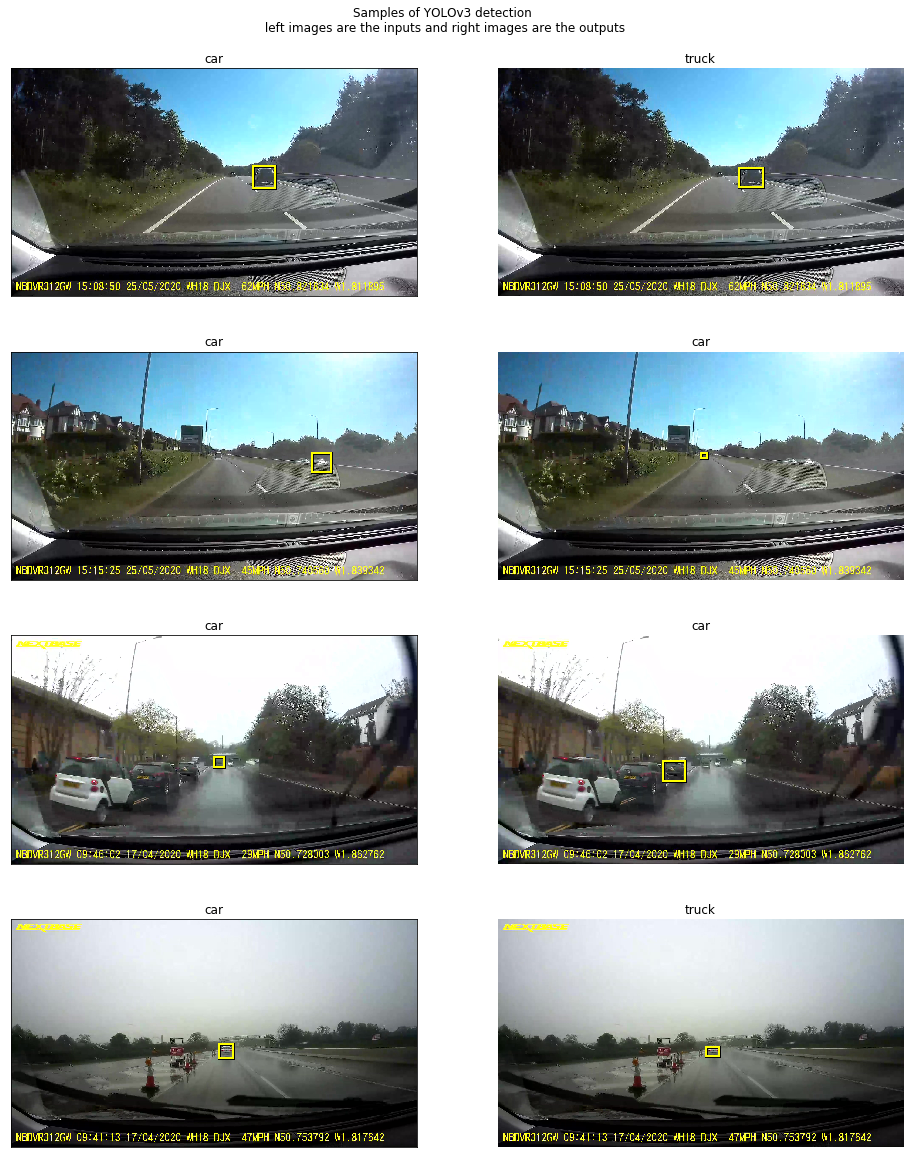

In [62]:
#ix = [random.randrange(0,frames_list.shape[0]) for i in range(6)] 

ix = random.sample(detected_idx, 4)
fig,ax = plt.subplots(len(ix),2,figsize=(16,20))
ttl = fig.suptitle(f'Samples of YOLOv3 detection\n left images are the inputs and right images are the outputs')
ttl.set_position([.5, .92])
for i in tqdm(ix):
    # showing the input bbox
    lbl,bbox = bbox_inp(i)
    
    show_inp(i,lbl=lbl,bbox=bbox,ax=ax[ix.index(i),0])
    # showing the predicted bbox
     
    detections = YOLO_pred(i)[0]
    ax[ix.index(i),1].axis('off')
    if detections is not None:
        show_pred_Yolo(i,detections=detections,ax=ax[ix.index(i),1])

## Faster_RCNN

RCNN is short for region-based Convolutional Neural Networks, and the idea behind this algorithm consists of two key steps. The algorithm will first perform a selective search (agglomerative hierarchical grouping) to identify bounding-box object region candidates. Once this is done, CNN features from each region are extraction independantly for classification (Girshick et al. 2014).  
Fast_RCNN is a more modern variation of RCNN which is claimed to improve both accuracy and speed by the original author. Fast_RCNN aims to improve on RCNN in 4 significant ways, which are as follows: 1. Higher detection quality than RCNN. 2. Training is single-stage, and uses multi-task loss. 3. Training updates all network layers. 4. No disk storage required for feature caching.
As opposed to extracting CNN features independantly from each region, Fast_RCNN aggregates them on the full image, and each region shares the feature map. Computation is easily shared as a result of Fast_RCNN methods, which is why it significantly speeds up training and test times. For example, Fast_RCNN was found to train the VGG16 network 9x faster than R_CNN, and is 213X faster at test time. (Girshick, 2015). 
Despite the improved speeds over RCNN, single neural network object detector systems still claim to be much faster, which includes the two other algorithms we will be using for this project.

In [63]:
os.chdir('..')

In [64]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

### <a href="https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/">Parametrs</a> 




For FAST_RCNN we found a pre-trained network which was tranied on a different COCO names. SO we had to define another COCO names.

In [65]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

i2c = lambda i : [k for k,v in targets.items() if v ==i]
c2i = {k:v for v,k in enumerate(COCO_INSTANCE_CATEGORY_NAMES)}

targets= {'car':c2i['car'],'truck':c2i['truck'],'bus':c2i['bus'],'motorcycle':c2i['motorcycle']} # object classes
targets

{'car': 3, 'truck': 8, 'bus': 6, 'motorcycle': 4}

In [66]:
# input image size
inp_w = 300
inp_h = 400

In [67]:
# to predict the dataset in the loop
def FRCNN_pred(img_idx,root_dir ='Frames/'):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    img = PIL.Image.open(img_path)
    
    imh,imw = detect_image(img)
    
    
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)), 
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])

    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    with torch.no_grad():
        detections = model(input_img)
        
    return detections
    

### Loading Faster_RCNN

In [68]:
# loading the model
torch.cuda.empty_cache()

model = fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

### Prdediction

In [69]:
class_correct_FRCNN = {'car':0,'truck':0,'bus':0,'motorcycle':0} # to count number of correct detected classes
class_notcorrect_FRCNN = {'car':0,'truck':0,'bus':0,'motorcycle':0}

class_correct_FRCNN_night = {'car':0,'truck':0,'motorcycle':0}   #per condition split
class_notcorrect_FRCNN_night = {'car':0,'truck':0,'motorcycle':0} # night doesnt have bus messes up recall later on

class_correct_FRCNN_rain = {'car':0,'truck':0,'bus':0} # rain doesnt have motorcycle it messes up recall formula later
class_notcorrect_FRCNN_rain = {'car':0,'truck':0,'bus':0}

class_correct_FRCNN_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0} 
class_notcorrect_FRCNN_clear = {'car':0,'truck':0,'bus':0,'motorcycle':0}

root_dir = 'Frames/'
correct = 0
detected = 0
not_detected = 0
trsh = .8
detected_idx =[] # keeping the indexes of detected images for plotting
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    
    if 'Night' in frames_list.iloc[image_idx,0]:
        condition = 'night'
    elif 'Rainy' in frames_list.iloc[image_idx,0]:
        condition = 'rain'
    else:
        condition = 'clear'
    
    detections = FRCNN_pred(image_idx)
    
    if detections is not None:
                detected_idx.append(image_idx)
                labels = detections[0]['labels'].cpu().tolist()
                scores = detections[0]['scores'].cpu().tolist()
                scores_ =[x for x in scores if x>trsh] # applying a threshold to the confidence scores
                
                if len(scores_)!=0:
                    scores_.sort()
                    mx_scores_idx =scores_.index(scores_[-1]) # finding the maximum score
                    
                    if mx_scores_idx !=0:
                        y_ = labels[:mx_scores_idx+1] # 
                else:
                    y_ =[]
                    
                if len(y_)!=0:    

                    if y in y_:
                        class_correct_FRCNN[cls_name] +=1
                        correct +=1
                        if condition == 'night':
                            class_correct_FRCNN_night[cls_name] += 1
                        elif condition == 'rain':
                            class_correct_FRCNN_rain[cls_name] += 1
                        else:
                            class_correct_FRCNN_clear[cls_name] += 1 
                    else:
                        class_notcorrect_FRCNN[cls_name] +=1
                        if condition == 'night':
                            class_notcorrect_FRCNN_night[cls_name] += 1
                        elif condition == 'rain':
                            class_notcorrect_FRCNN_rain[cls_name] += 1
                        else:
                            class_notcorrect_FRCNN_clear[cls_name] += 1 
                        

                else:
                     not_detected+=1

In [71]:
# claclute the number of not detected objects per class
correct_notcorrect ={k:class_correct_FRCNN.get(k, 0) + class_notcorrect_FRCNN.get(k, 0) for k in set(class_correct_FRCNN)}

class_not_detected = {k: class_total.get(k, 0) - correct_notcorrect.get(k, 0) for k in set(class_total)}

detected = frames_list.shape[0]-not_detected

#rain not detected
correct_notcorrect_rain ={k:class_correct_FRCNN_rain.get(k, 0) + class_notcorrect_FRCNN_rain.get(k, 0) for k in set(class_correct_FRCNN_rain)}

class_not_detected_rain = {k: cls_cnt_rain.get(k, 0) - correct_notcorrect_rain.get(k, 0) for k in set(cls_cnt_rain)}

#night not detected
correct_notcorrect_night ={k:class_correct_FRCNN_night.get(k, 0) + class_notcorrect_FRCNN_night.get(k, 0) for k in set(class_correct_FRCNN_night)}

class_not_detected_night = {k: cls_cnt_night.get(k, 0) - correct_notcorrect_night.get(k, 0) for k in set(cls_cnt_night)}

#clear not detected
correct_notcorrect_clear ={k:class_correct_FRCNN_clear.get(k, 0) + class_notcorrect_FRCNN_clear.get(k, 0) for k in set(class_correct_FRCNN_clear)}

class_not_detected_clear = {k: cls_cnt_clear.get(k, 0) - correct_notcorrect_clear.get(k, 0) for k in set(cls_cnt_clear)}

In [72]:
arrays = [['Overall','Overall','Overall','Rain Condition', 'Rain Condition', 'Rain Condition', 'Night Condition', 'Night Condition', 'Night Condition', 'Clear Condition', 'Clear Condition','Clear Condition']
          ,['precision', 'recall', 'f1','precision', 'recall', 'f1','precision', 'recall', 'f1','precision', 'recall', 'f1']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['condition', 'metric'])
FRCNN_stats = pd.DataFrame(index=index,
                      columns=['car','truck','bus','motorcycle'])


In [78]:
print(color.BOLD + 'FRCNN Overall' + color.END)
print(f'Accuracy of the FRCNNV3 on the {frames_list.shape[0]} test images: {100 * correct /frames_list.shape[0]:0.2f}%\n'
    
)
precisions = {'car':0,'truck':0,'bus':0,'motorcycle':0}
recalls = {'car':0,'truck':0,'bus':0,'motorcycle':0}
f1s = {'car':0,'truck':0,'bus':0,'motorcycle':0}
for k,_ in class_correct_FRCNN.items():
    #precision_FRCNN = division(class_correct_FRCNN[k],class_notcorrect_FRCNN[k]+class_correct_FRCNN[k])
    precision_FRCNN = precision(class_correct_FRCNN[k],class_notcorrect_FRCNN[k])
    precisions[k]=precision_FRCNN
    FRCNN_stats.loc['Overall','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_FRCNN:0.3f}')
  
    #recall_FRCNN = division(class_correct_FRCNN[k],class_correct_FRCNN[k]+class_not_detected[k])
    recall_FRCNN = recall(class_correct_FRCNN[k],(sum(class_notcorrect_FRCNN.values())-class_notcorrect_FRCNN[k]))
    recalls[k]=recall_FRCNN
    FRCNN_stats.loc['Overall','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_FRCNN:0.3f}')
    
    #F1_FRCNN = 2*(division((recall_FRCNN*precision_FRCNN),(recall_FRCNN+precision_FRCNN)))
    F1_FRCNN = F1(precision_FRCNN,recall_FRCNN)
    f1s[k]=F1_FRCNN
    FRCNN_stats.loc['Overall','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_FRCNN:0.3f}')
    
    print('')
    
print(color.BOLD + 'Rain Condition' + color.END)
print(f'Accuracy of the FRCNNV3 on {sum(cls_cnt_rain.values())} Rain test images: {100 * sum(class_correct_FRCNN_rain.values())/sum(cls_cnt_rain.values()):0.2f}%\n'
    
)

for k,_ in class_correct_FRCNN_rain.items():
    
    #precision_FRCNN_rain = division(class_correct_FRCNN_rain[k],class_notcorrect_FRCNN_rain[k]+class_correct_FRCNN_rain[k])
    precision_FRCNN_rain = precision(class_correct_FRCNN_rain[k],class_notcorrect_FRCNN_rain[k])
    precisions[k]=precision_FRCNN_rain 
    FRCNN_stats.loc['Rain Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_FRCNN_rain:0.3f}')
  
    #recall_FRCNN_rain = division(class_correct_FRCNN_rain[k],class_correct_FRCNN_rain[k]+class_not_detected_rain[k])
    recall_FRCNN_rain= recall(class_correct_FRCNN_rain[k],(sum(class_notcorrect_FRCNN_rain.values())-class_notcorrect_FRCNN_rain[k]))
    recalls[k]=recall_FRCNN_rain
    FRCNN_stats.loc['Rain Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_FRCNN_rain:0.3f}')
    
    #F1_FRCNN_rain = 2*(division((recall_FRCNN_rain*precision_FRCNN_rain),(recall_FRCNN_rain+precision_FRCNN_rain)))
    F1_FRCNN_rain = F1(precision_FRCNN_rain,recall_FRCNN_rain)
    f1s[k]=F1_FRCNN_rain
    FRCNN_stats.loc['Rain Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_FRCNN_rain:0.3f}')
    
    print('')

print(color.BOLD + 'Night Condition' + color.END)
print(f'Accuracy of the FRCNNV3 on {sum(cls_cnt_night.values())} Night test images: {100 * sum(class_correct_FRCNN_night.values())/sum(cls_cnt_night.values()):0.2f}%\n'
    
)

for k,_ in class_correct_FRCNN_night.items():
    
    #precision_FRCNN_night = division(class_correct_FRCNN_night[k],class_notcorrect_FRCNN_night[k]+class_correct_FRCNN_night[k])
    precision_FRCNN_night = precision(class_correct_FRCNN_night[k],(sum(class_notcorrect_FRCNN_night.values())-class_notcorrect_FRCNN_night[k]))
    precisions[k]=precision_FRCNN_night
    FRCNN_stats.loc['Night Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_FRCNN_night:0.3f}')
  
    #recall_FRCNN_night = division(class_correct_FRCNN_night[k],class_correct_FRCNN_night[k]+class_not_detected_night[k])
    recall_FRCNN_night= recall(class_correct_FRCNN_night[k],class_not_detected_night[k])
    recalls[k]=recall_FRCNN_night
    FRCNN_stats.loc['Night Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_FRCNN_night:0.3f}')
    
    #F1_FRCNN_night = 2*(division((recall_FRCNN_night*precision_FRCNN_night),(recall_FRCNN_night+precision_FRCNN_night)))
    F1_FRCNN_night = F1(precision_FRCNN_night,recall_FRCNN_night)
    f1s[k]=F1_FRCNN_night
    FRCNN_stats.loc['Night Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_FRCNN_night:0.3f}')
    
    print('')
    
print(color.BOLD + 'Clear Condition' + color.END)
print(f'Accuracy of the FRCNN on {sum(cls_cnt_clear.values())} Clear test images: {100 * sum(class_correct_FRCNN_clear.values())/sum(cls_cnt_clear.values()):0.2f}%\n'
    
)

for k,_ in class_correct_FRCNN_clear.items():
    
    #precision_FRCNN_clear = division(class_correct_FRCNN_clear[k],class_notcorrect_FRCNN_clear[k]+class_correct_FRCNN_clear[k])
    precision_FRCNN_clear = precision(class_correct_FRCNN_clear[k],class_notcorrect_FRCNN_clear[k])
    precisions[k]=precision_FRCNN_clear
    FRCNN_stats.loc['Clear Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_FRCNN_clear:0.3f}')
  
    #recall_FRCNN_clear = division(class_correct_FRCNN_clear[k],class_correct_FRCNN_clear[k]+class_not_detected_clear[k])
    recall_FRCNN_clear= recall(class_correct_FRCNN_clear[k],(sum(class_notcorrect_FRCNN_clear.values())-class_notcorrect_FRCNN_clear[k]))
    recalls[k]=recall_FRCNN_clear
    FRCNN_stats.loc['Clear Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_FRCNN_clear:0.3f}')
    
    #F1_FRCNN_clear = 2*(division((recall_FRCNN_clear*precision_FRCNN_clear),(recall_FRCNN_clear+precision_FRCNN_clear)))
    F1_FRCNN_clear = F1(precision_FRCNN_clear,recall_FRCNN_clear)
    f1s[k]=F1_FRCNN_clear
    FRCNN_stats.loc['Clear Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_FRCNN:0.3f}')
    
    print('')
    


FRCNN Overall
Accuracy of the FRCNNV3 on the 29539 test images: 47.66%

precision of car: 0.992
recall of car: 0.980
F1 of car: 0.986

precision of truck: 0.208
recall of truck: 0.247
F1 of truck: 0.226

precision of bus: 0.000
recall of bus: 0.000
F1 of bus: 0.000

precision of motorcycle: 0.000
recall of motorcycle: 0.000
F1 of motorcycle: 0.000

Rain Condition
Accuracy of the FRCNNV3 on 9413 Rain test images: 50.95%

precision of car: 0.985
recall of car: 0.961
F1 of car: 0.973

precision of truck: 0.124
recall of truck: 0.260
F1 of truck: 0.168

precision of bus: 0.000
recall of bus: 0.000
F1 of bus: 0.000

Night Condition
Accuracy of the FRCNNV3 on 6226 Night test images: 11.32%

precision of car: 0.968
recall of car: 0.115
F1 of car: 0.205

precision of truck: 0.182
recall of truck: 0.083
F1 of truck: 0.114

precision of motorcycle: 0.000
recall of motorcycle: 0.000
F1 of motorcycle: 0.000

Clear Condition
Accuracy of the FRCNN on 13900 Clear test images: 61.70%

precision of car

In [90]:
FRCNN_stats

car      truck  bus motorcycle
condition       metric                                        
Overall         precision  0.991863   0.208481    0          0
                recall       0.9798   0.246862    0          0
                f1         0.985795   0.226054    0          0
Rain Condition  precision  0.984924   0.124424    0        NaN
                recall     0.960911   0.259615    0        NaN
                f1         0.972769   0.168224    0        NaN
Night Condition precision  0.968144   0.181818  NaN          0
                recall     0.114778  0.0833333  NaN          0
                f1         0.205226   0.114286  NaN          0
Clear Condition precision  0.998249   0.702703    0          0
                recall     0.991649   0.254902    0          0
                f1         0.994938   0.374101    0          0

## SSD

SSD (Single Shot MultiBox Detector) is the final image-detection algorithm we will be testing on our own data. As described by the authors, SSD detects objects in images using a single deep neural network. 

To expand on this, the approach of SSD discretizes the output space of bounding boxes, creating a set of default boxes over various aspect ratios per feature map location. Once the algorithm must begin to predict, a score is generated for the presence of each object category in all the default boxes. Predictions from different feature maps are combined to handle objects of different sizes. SSD eliminates the need for proposal generation and feature resampling stages, and similiar to YOLO, all computation is focused in a single network. Therefore, training and testing is both easy and fast. YOLO can struggle with objects in usual aspect ratios, but SSD allows more aspect ratios and seperate predictions by aspect ratios, and therefore is claimed by the authors to have improved accuracy over YOLO (original version). 

SSD does have limitations however, objects with similiar categories can often confuse the algorithm, due to locations being shared for multiple classes. It can also struggle with smaller objects, as they not be present in all feature maps.(Liu et al. 2016)

For doing prediction with SSD we used a pretrained  <a href="https://github.com/qfgaohao/pytorch-ssd">SSD-vgg16</a>

In [128]:
#!git clone "https://github.com/qfgaohao/pytorch-ssd.git"
os.chdir('pytorch-ssd')

In [129]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.utils.misc import Timer
import cv2

### Parameters

Since this model has been trained on VOC dataset and 'truck' is not a valid class in this dataset, we first had to remove 'truck' from our dataset.

In [130]:
csv_file = '../mergedlbls.csv'
frames_list = pd.read_csv(csv_file)
trucks = frames_list.loc[frames_list.class_id == 'truck']
truck_indexes = trucks.index
frames_list = frames_list.drop(index=truck_indexes)
frames_list.head()

,im_name,class_id,Xc,Yc,w,h
0,ClearDay3/00000.jpg,car,1376,502,68,23
1,ClearDay3/00000.jpg,car,1144,490,23,17
2,ClearDay3/00001.jpg,car,1481,512,91,34
3,ClearDay3/00001.jpg,car,1160,494,25,17
4,ClearDay3/00002.jpg,car,1653,517,124,49


The new dataset has 3 classes as follows:

In [131]:
cls_cnt = frames_list.iloc[:,1].value_counts()
cls_cnt_rain = frames_list[frames_list['im_name'].str.contains('Rainy')].iloc[:,1].value_counts().to_dict()
cls_cnt_night = frames_list[frames_list['im_name'].str.contains('Night')].iloc[:,1].value_counts().to_dict()
cls_cnt_clear = frames_list[frames_list['im_name'].str.contains('Clear')].iloc[:,1].value_counts().to_dict()
class_total =cls_cnt.to_dict()
class_total

{'car': 28627, 'motorcycle': 101, 'bus': 25}

we did a correspondace between the dataset classes and VOC classes

In [132]:
VOC_NAMES =['background','aeroplane','bicycle','bird','boat','bottle',
              'bus','car','cat','chair','cow','diningtable','dog','horse',
              'motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
c2i = {k:v for v,k in enumerate(VOC_NAMES)}
targets= {'car':c2i['car'],'bus':c2i['bus'],'motorcycle':c2i['motorbike']} # object classes
i2c = lambda i : [k for k,v in targets.items() if v ==i]
targets

{'car': 7, 'bus': 6, 'motorcycle': 14}

To download the weights for the pretrained model from <a href="https://storage.googleapis.com/models-hao/vgg16-ssd-mp-0_7726.pth">here</a>

In [133]:
model_path = 'vgg16-ssd-mp-0_7726.pth'

### loading model

In [134]:
torch.cuda.empty_cache()
model = create_vgg_ssd(len(VOC_NAMES), is_test=True)

model.load(model_path)

In [135]:
predictor = create_vgg_ssd_predictor(model, candidate_size=200)

In [136]:
def SSD_pred(img_idx, trsh):
    
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    orig_image = cv2.imread(img_path)
    img = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    
    with torch.no_grad():
         bbox, classes, confidences = predictor.predict(img, 10, trsh)

    return bbox, classes, confidences
    

In [137]:
os.chdir('..')

### Prediction

In [101]:
class_correct_SSD = {'car':0,'bus':0,'motorcycle':0} # to count number of correct detected classes
class_notcorrect_SSD = {'car':0,'bus':0,'motorcycle':0}

class_correct_SSD_night = {'car':0,'motorcycle':0}   #per condition split
class_notcorrect_SSD_night = {'car':0,'motorcycle':0} # night doesnt have bus messes up recall later on

class_correct_SSD_rain = {'car':0,'bus':0} # rain doesnt have motorcycle it messes up recall formula later
class_notcorrect_SSD_rain = {'car':0,'bus':0}

class_correct_SSD_clear = {'car':0,'bus':0,'motorcycle':0} 
class_notcorrect_SSD_clear = {'car':0,'bus':0,'motorcycle':0}

root_dir = 'Frames/'
correct = 0
detected = 0
not_detected = 0
trsh = .5
old_stdout = sys.stdout
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    sys.stdout = open(os.devnull,'w') # to prevent print out the out put net results
    
    if 'Night' in frames_list.iloc[image_idx,0]:
        condition = 'night'
    elif 'Rainy' in frames_list.iloc[image_idx,0]:
        condition = 'rain'
    else:
        condition = 'clear'
    
    _,y_,confidences = SSD_pred(image_idx,trsh)

    if y_.size()[0] !=0:
        
        if y in y_:
            class_correct_SSD[cls_name] +=1
            correct +=1
            if condition == 'night':
                class_correct_SSD_night[cls_name] += 1
            elif condition == 'rain':
                class_correct_SSD_rain[cls_name] += 1
            else:
                class_correct_SSD_clear[cls_name] += 1
        else:
            class_notcorrect_SSD[cls_name] +=1
            
            if condition == 'night':
                class_notcorrect_SSD_night[cls_name] += 1
            elif condition == 'rain':
                class_notcorrect_SSD_rain[cls_name] += 1
            else:
                class_notcorrect_SSD_clear[cls_name] += 1 
    else:
         not_detected+=1


In [103]:
# to enable print
sys.stdout.close()
sys.stdout = old_stdout

In [104]:
# claclute the number of not detected objects per class
correct_notcorrect ={k:class_correct_SSD.get(k, 0) + class_notcorrect_SSD.get(k, 0) for k in set(class_correct_SSD)}

class_not_detected = {k: class_total.get(k, 0) - correct_notcorrect.get(k, 0) for k in set(class_total)}

detected = frames_list.shape[0]-not_detected

#rain not detected
correct_notcorrect_rain ={k:class_correct_SSD_rain.get(k, 0) + class_notcorrect_SSD_rain.get(k, 0) for k in set(class_correct_SSD_rain)}

class_not_detected_rain = {k: cls_cnt_rain.get(k, 0) - correct_notcorrect_rain.get(k, 0) for k in set(cls_cnt_rain)}

#night not detected
correct_notcorrect_night ={k:class_correct_SSD_night.get(k, 0) + class_notcorrect_SSD_night.get(k, 0) for k in set(class_correct_SSD_night)}

class_not_detected_night = {k: cls_cnt_night.get(k, 0) - correct_notcorrect_night.get(k, 0) for k in set(cls_cnt_night)}

#clear not detected
correct_notcorrect_clear ={k:class_correct_SSD_clear.get(k, 0) + class_notcorrect_SSD_clear.get(k, 0) for k in set(class_correct_SSD_clear)}

class_not_detected_clear = {k: cls_cnt_clear.get(k, 0) - correct_notcorrect_clear.get(k, 0) for k in set(cls_cnt_clear)}

In [105]:
arrays = [['Overall','Overall','Overall','Rain Condition', 'Rain Condition', 'Rain Condition', 'Night Condition', 'Night Condition', 'Night Condition', 'Clear Condition', 'Clear Condition','Clear Condition']
          ,['precision', 'recall', 'f1','precision', 'recall', 'f1','precision', 'recall', 'f1','precision', 'recall', 'f1']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['condition', 'metric'])
SSD_stats = pd.DataFrame(index=index,
                      columns=['car','truck','bus','motorcycle'])


In [108]:
print(color.BOLD + 'SSD Overall' + color.END)
print(f'Accuracy of the SSD on the {frames_list.shape[0]} test images: {100 * correct /frames_list.shape[0]:0.2f}%\n'
    
)
precisions = {'car':0,'truck':0,'bus':0,'motorcycle':0}
recalls = {'car':0,'truck':0,'bus':0,'motorcycle':0}
f1s = {'car':0,'truck':0,'bus':0,'motorcycle':0}
for k,_ in class_correct_SSD.items():
    #precision_SSD = division(class_correct_SSD[k],class_notcorrect_SSD[k]+class_correct_SSD[k])
    precision_SSD = precision(class_correct_SSD[k],class_notcorrect_SSD[k])
    precisions[k]=precision_SSD
    SSD_stats.loc['Overall','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_SSD:0.3f}')
  
    #recall_SSD = division(class_correct_SSD[k],class_correct_SSD[k]+class_not_detected[k])
    recall_SSD = recall(class_correct_SSD[k],(sum(class_notcorrect_SSD.values())-class_notcorrect_SSD[k]))
    recalls[k]=recall_SSD
    SSD_stats.loc['Overall','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_SSD:0.3f}')
    
    #F1_SSD = 2*(division((recall_SSD*precision_SSD),(recall_SSD+precision_SSD)))
    F1_SSD = F1(precision_SSD,recall_SSD)
    f1s[k]=F1_SSD
    SSD_stats.loc['Overall','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_SSD:0.3f}')
    
    print('')


print(color.BOLD + 'Rain Condition' + color.END)
print(f'Accuracy of the SSD on {sum(cls_cnt_rain.values())} Rain test images: {100 * sum(class_correct_SSD_rain.values())/sum(cls_cnt_rain.values()):0.2f}%\n'
    
)

for k,_ in class_correct_SSD_rain.items():
    
    #precision_SSD_rain = division(class_correct_SSD_rain[k],class_notcorrect_SSD_rain[k]+class_correct_SSD_rain[k])
    precision_SSD_rain = precision(class_correct_SSD_rain[k],class_notcorrect_SSD_rain[k])
    precisions[k]=precision_SSD_rain 
    SSD_stats.loc['Rain Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_SSD_rain:0.3f}')
  
    #recall_SSD_rain = division(class_correct_SSD_rain[k],class_correct_SSD_rain[k]+class_not_detected_rain[k])
    recall_SSD_rain= recall(class_correct_SSD_rain[k],(sum(class_notcorrect_SSD_rain.values())-class_notcorrect_SSD_rain[k]))
    recalls[k]=recall_SSD_rain
    SSD_stats.loc['Rain Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_SSD_rain:0.3f}')
    
    #F1_SSD_rain = 2*(division((recall_SSD_rain*precision_SSD_rain),(recall_SSD_rain+precision_SSD_rain)))
    F1_SSD_rain = F1(precision_SSD_rain,recall_SSD_rain)
    f1s[k]=F1_SSD_rain
    SSD_stats.loc['Rain Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_SSD_rain:0.3f}')
    
    print('')


print(color.BOLD + 'Night Condition' + color.END)
print(f'Accuracy of the SSD on {sum(cls_cnt_night.values())} Night test images: {100 * sum(class_correct_SSD_night.values())/sum(cls_cnt_night.values()):0.2f}%\n'
    
)

for k,_ in class_correct_SSD_night.items():
    
    #precision_SSD_night = division(class_correct_SSD_night[k],class_notcorrect_SSD_night[k]+class_correct_SSD_night[k])
    precision_SSD_night = precision(class_correct_SSD_night[k],class_notcorrect_SSD_night[k])
    precisions[k]=precision_SSD_night
    SSD_stats.loc['Night Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_SSD_night:0.3f}')
  
    #recall_SSD_night = division(class_correct_SSD_night[k],class_correct_SSD_night[k]+class_not_detected_night[k])
    recall_SSD_night= recall(class_correct_SSD_night[k],(sum(class_notcorrect_SSD_night.values())-class_notcorrect_SSD_night[k]))
    recalls[k]=recall_SSD_night
    SSD_stats.loc['Night Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_SSD_night:0.3f}')
    
    #F1_SSD_night = 2*(division((recall_SSD_night*precision_SSD_night),(recall_SSD_night+precision_SSD_night)))
    F1_SSD_night = F1(precision_SSD_night,recall_SSD_night)
    f1s[k]=F1_SSD_night
    SSD_stats.loc['Night Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_SSD_night:0.3f}')
    
    print('')
    
print(color.BOLD + 'Clear Condition' + color.END)
print(f'Accuracy of the SSD on {sum(cls_cnt_clear.values())} Clear test images: {100 * sum(class_correct_SSD_clear.values())/sum(cls_cnt_clear.values()):0.2f}%\n')

for k,_ in class_correct_SSD_clear.items():
    
    #precision_SSD_clear = division(class_correct_SSD_clear[k],class_notcorrect_SSD_clear[k]+class_correct_SSD_clear[k])
    precision_SSD_clear = precision(class_correct_SSD_clear[k],(sum(class_notcorrect_SSD_clear.values())-class_notcorrect_SSD_clear[k]))
    precisions[k]=precision_SSD_clear
    SSD_stats.loc['Clear Condition','precision'][k]=precisions[k]
    print(f'precision of {k}: {precision_SSD_clear:0.3f}')
  
    #recall_SSD_clear = division(class_correct_SSD_clear[k],class_correct_SSD_clear[k]+class_not_detected_clear[k])
    recall_SSD_clear= recall(class_correct_SSD_clear[k],class_not_detected_clear[k])
    recalls[k]=recall_SSD_clear
    SSD_stats.loc['Clear Condition','recall'][k]=recalls[k]
    print(f'recall of {k}: {recall_SSD_clear:0.3f}')
    
    #F1_SSD_clear = 2*(division((recall_SSD_clear*precision_SSD_clear),(recall_SSD_clear+precision_SSD_clear)))
    F1_SSD_clear = F1(precision_SSD_clear,recall_SSD_clear)
    f1s[k]=F1_SSD_clear
    SSD_stats.loc['Clear Condition','f1'][k]=f1s[k]
    print(f'F1 of {k}: {F1_SSD_clear:0.3f}')
    
    print('')



SSD Overall
Accuracy of the SSD on the 28753 test images: 21.70%

precision of car: 0.678
recall of car: 0.996
F1 of car: 0.807

precision of bus: 0.000
recall of bus: 0.000
F1 of bus: 0.000

precision of motorcycle: 0.000
recall of motorcycle: 0.000
F1 of motorcycle: 0.000

Rain Condition
Accuracy of the SSD on 8763 Rain test images: 25.41%

precision of car: 0.547
recall of car: 0.998
F1 of car: 0.707

precision of bus: 0.000
recall of bus: 0.000
F1 of bus: 0.000

Night Condition
Accuracy of the SSD on 6131 Night test images: 23.21%

precision of car: 0.877
recall of car: 0.998
F1 of car: 0.933

precision of motorcycle: 0.000
recall of motorcycle: 0.000
F1 of motorcycle: 0.000

Clear Condition
Accuracy of the SSD on 13859 Clear test images: 18.69%

precision of car: 0.993
recall of car: 0.202
F1 of car: 0.335

precision of bus: 0.000
recall of bus: 0.000
F1 of bus: 0.000

precision of motorcycle: 0.000
recall of motorcycle: 0.000
F1 of motorcycle: 0.000



In [109]:
SSD_stats

car truck  bus motorcycle
condition       metric                                   
Overall         precision  0.677892   NaN    0          0
                recall     0.995851   NaN    0          0
                f1         0.806671   NaN    0          0
Rain Condition  precision   0.54704   NaN    0        NaN
                recall     0.998207   NaN    0        NaN
                f1          0.70676   NaN    0        NaN
Night Condition precision  0.876771   NaN  NaN          0
                recall     0.997896   NaN  NaN          0
                f1         0.933421   NaN  NaN          0
Clear Condition precision  0.992718   NaN    0          0
                recall     0.201635   NaN    0          0
                f1         0.335188   NaN    0          0

# Discussion and Results

The results is divided overall and per condition comparing all detectors. Our plotting library of choice is Seaborn as it works conveniently well with pandas dataframe. Furthermore, please note it was not possible for us to detect Trucks with the SSD. Accuracy was manually taken from the results output of each section, the results might differ slightly.

In [110]:
# concat to call all data in one DF and reset index for easier plotting with seaborn
Yolo_stats['Detector'] = 'YoloV3'
FRCNN_stats['Detector'] = 'FRCNN'
SSD_stats['Detector'] = 'SSD'
statconcat = [Yolo_stats, FRCNN_stats, SSD_stats]
statconcat = pd.concat(statconcat)
df = statconcat.reset_index()

## Rain Condition Comparison

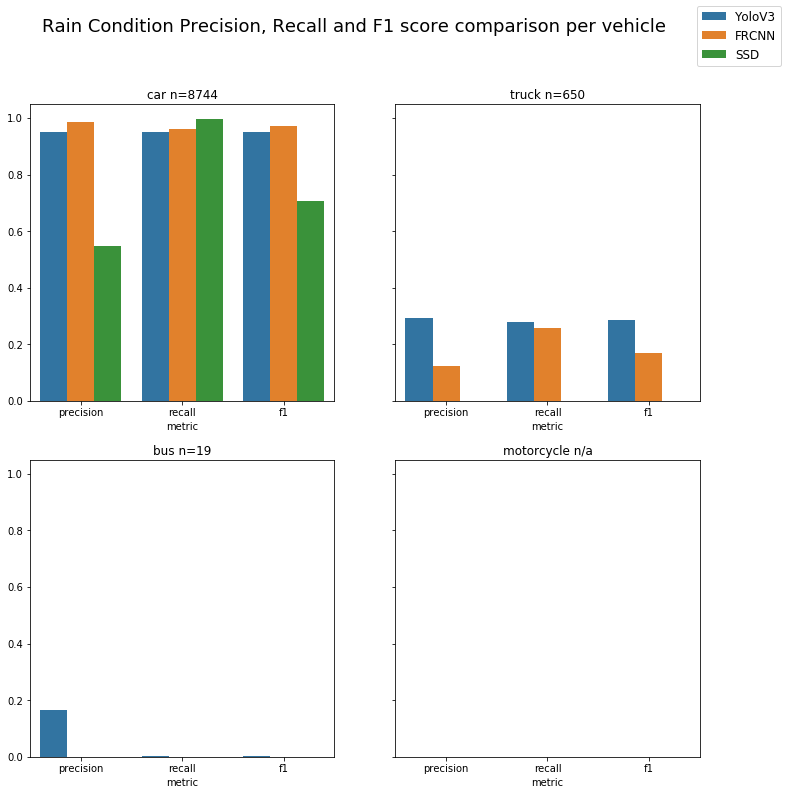

condition  Rain Condition                   
metric                 f1        f1       f1
car              0.950548  0.972769  0.70676
truck            0.286049  0.168224      NaN
bus            0.00327332         0        0
motorcycle            NaN       NaN      NaN
Detector           YoloV3     FRCNN      SSD

In [111]:
f, ax = plt.subplots(2,2, figsize=(12,12), sharey=True)

ax1 = sns.barplot(data=df[df['condition']=='Rain Condition'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[0,0])
ax2 = sns.barplot(data=df[df['condition']=='Rain Condition'], x = 'metric', y = 'truck', hue= 'Detector', ax=ax[0,1])
ax3 = sns.barplot(data=df[df['condition']=='Rain Condition'], x = 'metric', y = 'bus', hue= 'Detector', ax=ax[1,0])
ax4 = sns.barplot(data=df[df['condition']=='Rain Condition'], x = 'metric', y = 'motorcycle', hue= 'Detector', ax=ax[1,1])

handles, lables = ax1.get_legend_handles_labels()
ax1.title.set_text('car n=8744'),ax2.title.set_text('truck n=650'),ax3.title.set_text('bus n=19'),ax4.title.set_text('motorcycle n/a')
ax1.legend_.remove(),ax2.legend_.remove(),ax3.legend_.remove(),ax4.legend_.remove()
ax1.set_ylabel(''),ax2.set_ylabel(''),ax3.set_ylabel(''),ax4.set_ylabel(''),
plt.figlegend(handles, lables, loc = 'upper right', fontsize='large')
f.suptitle('Rain Condition Precision, Recall and F1 score comparison per vehicle', fontsize=18)
plt.show()
statconcat.loc[('Rain Condition', 'f1')].transpose()

### Rain condition

Note there was no motorcylce class in this condition

Accuracy within the rain conditions

- Yolo - 63.49%  
- FRCNN - 50.95%
- SSD - 25.41%

Overall within this condition a competitive performance from Yolo and FRCNN. FRCNN was more precise on detecting relevant objects labelled car while Yolo obtained a higher score in recall.

There appeared to be poor overall performance in detecting other classes. Both FRCNN and SSD failed to detect bus objects within this condition with Yolo being the only detector managing to identify some correctly, albiet at poort performance

## Night Condition Comparison

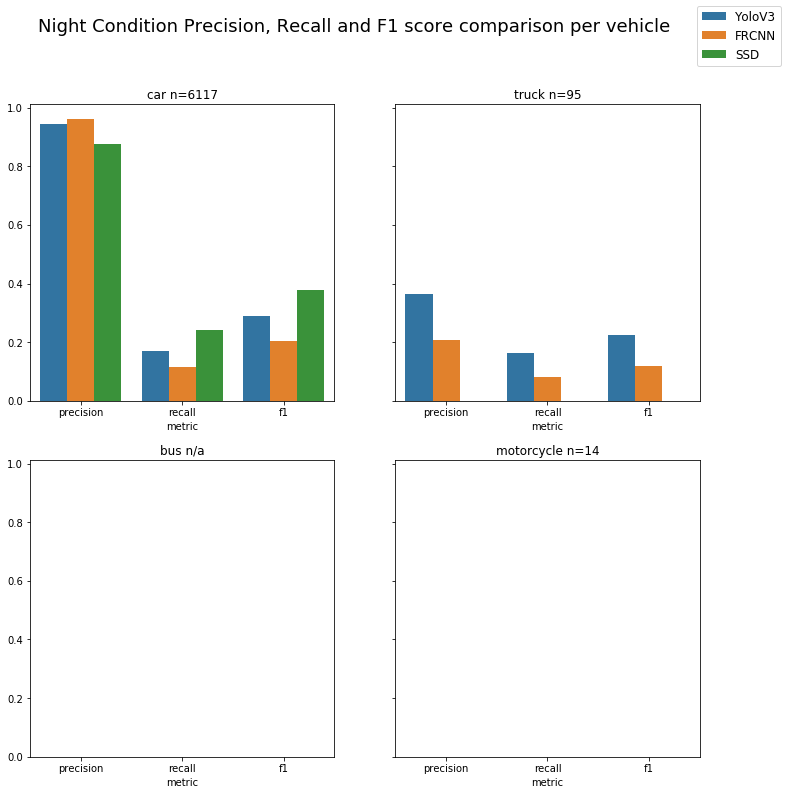

condition  Night Condition                    
metric                  f1        f1        f1
car               0.290147  0.205106  0.377454
truck             0.224299  0.118812       NaN
bus                    NaN       NaN       NaN
motorcycle               0         0         0
Detector            YoloV3     FRCNN       SSD

In [759]:
f, ax = plt.subplots(2,2, figsize=(12,12), sharey=True)

ax1 = sns.barplot(data=df[df['condition']=='Night Condition'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[0,0])
ax2 = sns.barplot(data=df[df['condition']=='Night Condition'], x = 'metric', y = 'truck', hue= 'Detector', ax=ax[0,1])
ax3 = sns.barplot(data=df[df['condition']=='Night Condition'], x = 'metric', y = 'bus', hue= 'Detector', ax=ax[1,0])
ax4 = sns.barplot(data=df[df['condition']=='Night Condition'], x = 'metric', y = 'motorcycle', hue= 'Detector', ax=ax[1,1])

handles, lables = ax1.get_legend_handles_labels()
ax1.title.set_text('car n=6117'),ax2.title.set_text('truck n=95'),ax3.title.set_text('bus n/a'),ax4.title.set_text('motorcycle n=14')
ax1.legend_.remove(),ax2.legend_.remove(),ax3.legend_.remove(),ax4.legend_.remove()
ax1.set_ylabel(''),ax2.set_ylabel(''),ax3.set_ylabel(''),ax4.set_ylabel(''),
plt.figlegend(handles, lables, loc = 'upper right', fontsize='large')
f.suptitle('Night Condition Precision, Recall and F1 score comparison per vehicle', fontsize=18)
plt.show()
statconcat.loc[('Night Condition', 'f1')].transpose()

### Night condition

Note there was no bus class in this condition

Accuracy within the night conditions

- Yolo - 16.86%
- FRCNN - 11.32%
- SSD - 23.21%

Overall accuracy during night condition was generally poor from all of the detectors. Though its worth noting that SSD obtained the highest F1 score within this harsher environment with low lighting. 

None of the detectors managed to correctly detect motorcylces within this condition

Yolo performed better at correctly detecting trucks vs FRCNN though overall performance was still poor

## Clear Condition Comparison

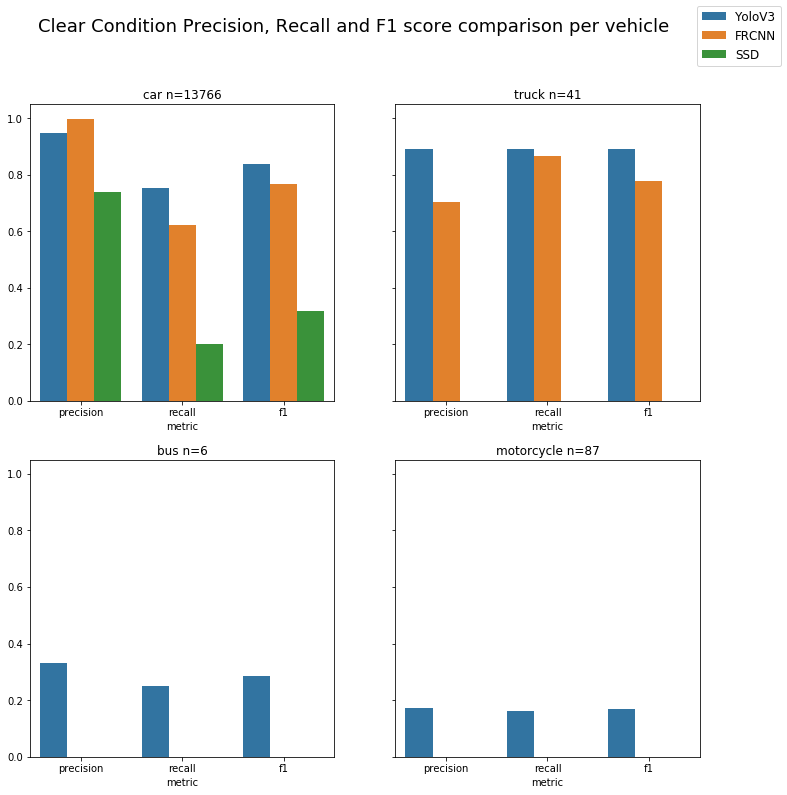

condition  Clear Condition                    
metric                  f1        f1        f1
car               0.837773  0.766266  0.316703
truck             0.891892  0.776119       NaN
bus               0.285714         0         0
motorcycle        0.168421         0         0
Detector            YoloV3     FRCNN       SSD

In [758]:
f, ax = plt.subplots(2,2, figsize=(12,12), sharey=True)

ax1 = sns.barplot(data=df[df['condition']=='Clear Condition'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[0,0])
ax2 = sns.barplot(data=df[df['condition']=='Clear Condition'], x = 'metric', y = 'truck', hue= 'Detector', ax=ax[0,1])
ax3 = sns.barplot(data=df[df['condition']=='Clear Condition'], x = 'metric', y = 'bus', hue= 'Detector', ax=ax[1,0])
ax4 = sns.barplot(data=df[df['condition']=='Clear Condition'], x = 'metric', y = 'motorcycle', hue= 'Detector', ax=ax[1,1])

handles, lables = ax1.get_legend_handles_labels()
ax1.title.set_text('car n=13766'),ax2.title.set_text('truck n=41'),ax3.title.set_text('bus n=6'),ax4.title.set_text('motorcycle n=87')
ax1.legend_.remove(),ax2.legend_.remove(),ax3.legend_.remove(),ax4.legend_.remove()
ax1.set_ylabel(''),ax2.set_ylabel(''),ax3.set_ylabel(''),ax4.set_ylabel(''),
plt.figlegend(handles, lables, loc = 'upper right', fontsize='large')
f.suptitle('Clear Condition Precision, Recall and F1 score comparison per vehicle', fontsize=18)
plt.show()
statconcat.loc[('Clear Condition', 'f1')].transpose()

### Clear condition

Accuracy within the clear conditions

- Yolo - 71.69%
- FRCNN - 61.70%
- SSD - 18.69%

Yolo overall managed to score the highest F1 score against the other two on all class labels. Yolo was also the only detector to correctly detect bus and motorcylce objects within this condition

# Overall Comparison

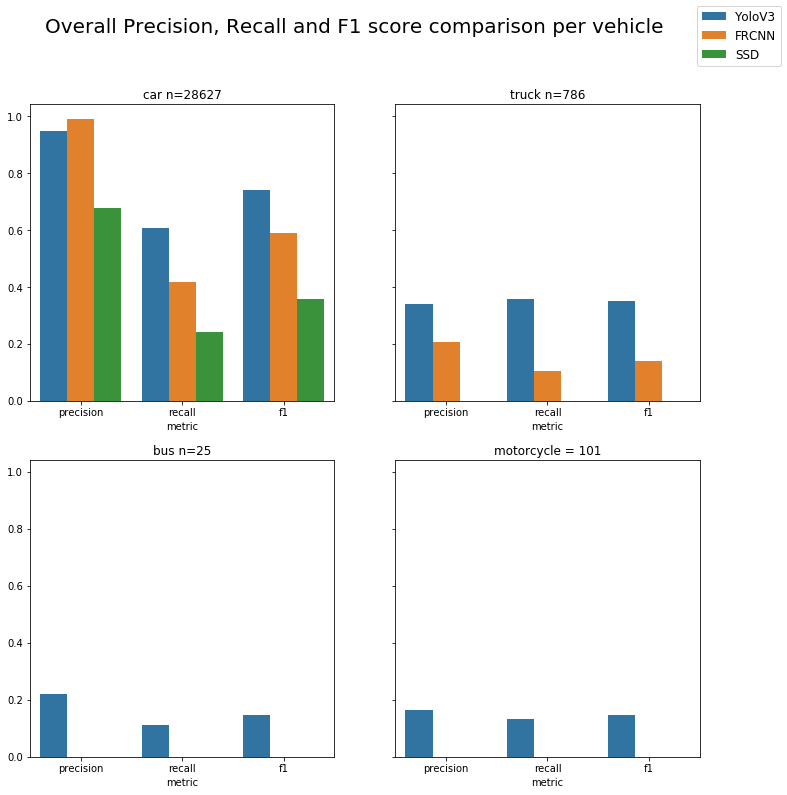

condition    Overall                    
metric            f1        f1        f1
car         0.740037  0.589326  0.357932
truck       0.350472  0.139645       NaN
bus         0.148148         0         0
motorcycle  0.146789         0         0
Detector      YoloV3     FRCNN       SSD

In [761]:
f, ax = plt.subplots(2,2, figsize=(12,12), sharey=True)

ax1 = sns.barplot(data=df[df['condition']=='Overall'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[0,0])
ax2 = sns.barplot(data=df[df['condition']=='Overall'], x = 'metric', y = 'truck', hue= 'Detector', ax=ax[0,1])
ax3 = sns.barplot(data=df[df['condition']=='Overall'], x = 'metric', y = 'bus', hue= 'Detector', ax=ax[1,0])
ax4 = sns.barplot(data=df[df['condition']=='Overall'], x = 'metric', y = 'motorcycle', hue= 'Detector', ax=ax[1,1])

handles, lables = ax1.get_legend_handles_labels()
ax1.title.set_text('car n=28627'),ax2.title.set_text('truck n=786'),ax3.title.set_text('bus n=25'),ax4.title.set_text('motorcycle = 101')
ax1.legend_.remove(),ax2.legend_.remove(),ax3.legend_.remove(),ax4.legend_.remove()
ax1.set_ylabel(''),ax2.set_ylabel(''),ax3.set_ylabel(''),ax4.set_ylabel(''),
plt.figlegend(handles, lables, loc = 'upper right', fontsize='large')
f.suptitle('Overall Precision, Recall and F1 score comparison per vehicle', fontsize=20)
plt.show()
statconcat.loc[('Overall', 'f1')].transpose()

### Overall comparison

Accuracy within the clear conditions

- Yolo - 57.52%
- FRCNN - 47.66%
- SSD - 21.21%

Yolo overall managed to score the highest F1 score against the other two. Yolo was also the only detector to correctly detect bus and motorcylce objects within this condition

## Car Vehicle focus

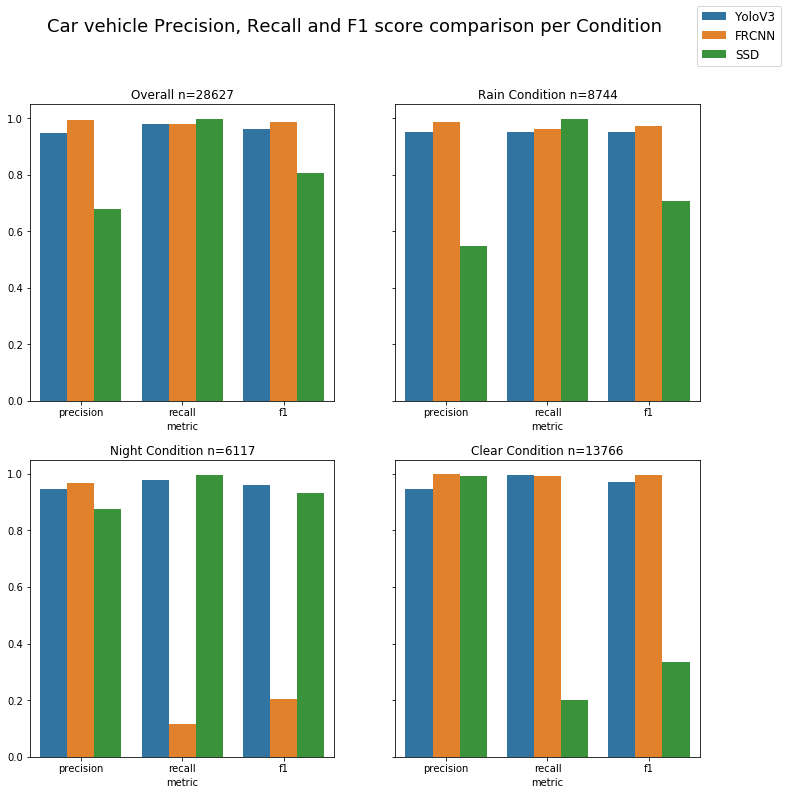

In [120]:
f, ax = plt.subplots(2,2, figsize=(12,12), sharey=True)

ax1 = sns.barplot(data=df[df['condition']=='Overall'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[0,0])
ax2 = sns.barplot(data=df[df['condition']=='Rain Condition'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[0,1])
ax3 = sns.barplot(data=df[df['condition']=='Night Condition'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[1,0])
ax4 = sns.barplot(data=df[df['condition']=='Clear Condition'], x = 'metric', y = 'car', hue= 'Detector', ax=ax[1,1])

handles, lables = ax1.get_legend_handles_labels()
ax1.title.set_text('Overall n=28627'),ax2.title.set_text('Rain Condition n=8744'),ax3.title.set_text('Night Condition n=6117')
ax4.title.set_text('Clear Condition n=13766')
ax1.legend_.remove(),ax2.legend_.remove(),ax3.legend_.remove(),ax4.legend_.remove()
ax1.set_ylabel(''),ax2.set_ylabel(''),ax3.set_ylabel(''),ax4.set_ylabel(''),
plt.figlegend(handles, lables, loc = 'upper right', fontsize='large')
f.suptitle('Car vehicle Precision, Recall and F1 score comparison per Condition', fontsize=18)
plt.show()

condition   Overall                     Rain Condition                     \
metric           f1        f1        f1             f1        f1       f1   
car        0.962615  0.985795  0.806671       0.950548  0.972769  0.70676   
Detector     YoloV3     FRCNN       SSD         YoloV3     FRCNN      SSD   

condition Night Condition                     Clear Condition            \
metric                 f1        f1        f1              f1        f1   
car              0.961111  0.205226  0.933421        0.970038  0.994938   
Detector           YoloV3     FRCNN       SSD          YoloV3     FRCNN   

condition            
metric           f1  
car        0.335188  
Detector        SSD

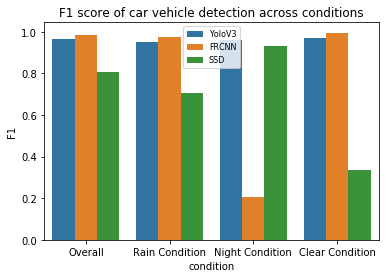

In [121]:
ax = sns.barplot(data=df[df['metric']=='f1'], x = 'condition', y = 'car', hue= 'Detector')
ax.set_title('F1 score of car vehicle detection across conditions')
ax.set_ylabel('F1')
ax.legend(loc='upper center', fontsize=8)
statconcat.loc[[('Overall', 'f1'), ('Rain Condition', 'f1'), ('Night Condition', 'f1')
              , ('Clear Condition', 'f1')], ['car', 'Detector']].transpose()

### Car vehicle performance 

Here we focus on car detection as it was the most active class

Yolo outperformed the other detectors in 2 out of the 3 conditions and SSD being the top performer within the night time condition.

However, overall SSD performed poorly in terms of overall accuracy only being competitive in this measure during night time with overall poor performance on all three detectors.



# Trial video

With Yolo outperforming FRCNN and SSD within this experiment, we wanted to showcase a video run of live detecting.

We followed this <a href = "https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98"> tutorial</a>

In [138]:
os.chdir('PyTorch-YOLOv3/')
#!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git

In [141]:
import models as net
import utils as utls

In [142]:
# We have to reload the yolo model
torch.cuda.empty_cache()
model = net.Darknet(cfg_file,img_size=inp_w)
model.load_darknet_weights(weight_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [143]:
# detec image function with torch no grad
def detect_image_trial(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utls.utils.non_max_suppression(detections, 
                        conf_thres, nms_thres)
    return detections[0]

In [808]:
# video loop manual range, while true breaks sometimes not reliable on current video

img_size=416
classes = utls.utils.load_classes(class_path)
videopath = '../Edited Videos/All_in_one.mp4'
#videopath = 'C:\\Users\Christine\OneDrive - Bournemouth University\Computer Vision\Project Data\RainyDay2.mp4'
#videopath = 'D:\\ObjectDetection_Compare_BU\Frames\RainyDay1\\%00002d.jpg'
%pylab inline 
from IPython.display import clear_output
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
# initialize Sort object and video capture
from pytorch_objectdetecttrack.sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort()

for ii in range(1000):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = PIL.Image.fromarray(frame)
    detections = detect_image_trial(pilimg)
    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])
            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h),
                         color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60,
                         y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), 
                        (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (255,255,255), 3)
    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)

KeyboardInterrupt: 

## Project Challenges

### Labeling
One thing that must be considered a challenge during this project was the labelling of the ground-truth bounding boxes on the test data. In particular, there may have been a lack of consistency when hand labelling for both an individual and between the group members. One group member could have decided to label as many objects as possible, including tiny objects far in the distance that may be hardly recognisable, where as another group member may wait until it is more discernable. Detection algorithms may struggle to pick up tiny objects from a distance, and it could be considered unfair to expect the algorithm to pick them up. These inconsistencies will affect the accuracy and F1 scores in an unfair manner. 

Similiary, a person labelling may simply miss some objects in the frames, whether they are overt or not. If a detection algorithm succesfully picks up what a person has missed, this will count negatively to the accuracy and performance scores, when in fact the opposite is true, the algorithm is performing better. 

### Results
Our detection implemention was very limited in scope. We essentially passed a frame and giving a ground truth without accounting for multi object detecting. A detected bounding box could very well be a correct identification but our code will count it as an incorrect response. We take this as a learning curve in multi object detection and hope to deliver a better implementation of a detector in this environment.


### SORT
The inconsistent results can be solved by using the Simple Online Realtime Tracking framework by Alex Bewley and colleagues(2016). Purely for keeping track and matching IDs in continous frames. The SORT framework is show cased on the video trial and it is something we could have adapted within our experiment.

### Training
All models could have used further training to enchance their performance and familiriaty of British centric vehicles. Though we did not implement it during this project, it is a crucial step to gain better performance as the pretrained algorithms were trained on domains that are more general than our subject. This would also have solved our problem with SSD having no Truck class label as we cant introduce it to the detector

### Uncontrolled Factors
We could not control for equality in labels for ground truth and a large majority of our test data were composed of one class. We also faced a problem where a condition did not have some class labels present such as no motorcycles during the rain or no buses at night.

# References

Bewley, A., Ge, Z., Ott, L., Ramos, F. and Upcroft, B., 2016, September. Simple online and realtime tracking. In 2016 IEEE International Conference on Image Processing (ICIP) (pp. 3464-3468). IEEE.

Dasiopoulou, S., Mezaris, V., Kompatsiaris, I., Papastathis, V. K., and Strintzis, M. G., 2005. Knowledge-assisted semantic video object detection. IEEE Transactions on Circuits and Systems for Video Technology, 15 (10).

Girshick, R., Donahue, J., Darrell, T., and Malik, J., 2014. Rich feature hierarchies for accurate object detection and semantic segmentation. In: Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition.

Girshick, R., 2015. Fast R-CNN, in: Proceedings of the IEEE International Conference on Computer Vision.

Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., and Berg, A. C., 2016. SSD: Single shot multibox detector. In: Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics).

Redmon, J., Divvala, S., Girshick, R., and Farhadi, A., 2016. You only look once: Unified, real-time object detection. In: Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition.

Sivaraman, S. and Trivedi, M. M., 2013. Looking at vehicles on the road: A survey of vision-based vehicle detection, tracking, and behavior analysis. IEEE Transactions on Intelligent Transportation Systems, 14 (4).

Dhamanam, N., Kathirvelu, D. M., and GovindaRao, T., 2020. Review of Environment Perception for Intelligent Vehicles. SSRN Electronic Journal.